# EM algorithm applied on univariate sample to identify the classes


# Summary of Learnings

The provided example helped me understand how the Expectation-Maximization (EM) algorithm works using a simple case of red and blue classes. Initially, randomly generated clusters are combined to form an unknown class of values, which are then clustered/classified using the EM algorithm.

The algorithm starts with an initial guess for the cluster parameters. It then iteratively performs two key steps: the Expectation (E) step and the Maximization (M) step.

- In the Expectation step, the likelihood of each data point belonging to a particular cluster is estimated, assigning a probability (or weight) to each point for each class.

- In the Maximization step, these calculated weights are used to update the mean and standard deviation for each class.

The output from the class segregation example demonstrates the effectiveness of this algorithm, achieving convergence in 20 iterations. However, it is important to note that the initial guesses for the class parameters can significantly impact the convergence speed and accuracy of the algorithm.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
np.random.seed(110)  # for reproducible results

# set the parameters for red and blue distributions which will generate 'height' data
red_mean = 160
red_std = 3

blue_mean = 170
blue_std = 5

In [3]:
# draw 50 samples from each normal distribution
red = np.random.normal(red_mean, red_std, size=50)
blue = np.random.normal(blue_mean, blue_std, size=50)

In [4]:
both_colours = np.sort(
    np.concatenate((red, blue))
)  # array with every sample point (for later use)

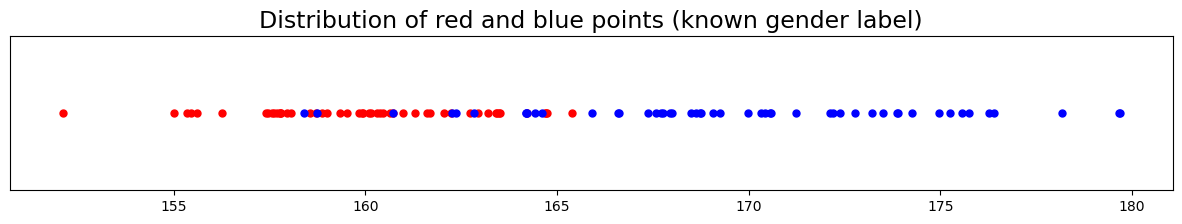

In [5]:
plt.figure
plt.rcParams["figure.figsize"] = (15, 2)
plt.plot(red, np.zeros_like(red), ".", color="r", markersize=10)
plt.plot(blue, np.zeros_like(blue), ".", color="b", markersize=10)
plt.title(r"Distribution of red and blue points (known gender label)", fontsize=17)
plt.yticks([])
plt.show()

In [6]:
# print descriptive statistics of generated data-- Our objective is
# to infer the parameters of the distribution from which the data was generated
print("Red class: Mean ", np.mean(red), " Std ", np.std(red))
print("Blue class: Mean ", np.mean(blue), " Std ", np.std(blue))

Red class: Mean  159.99117085624866  Std  2.928003470358192
Blue class: Mean  169.56765436768677  Std  5.087682119263838


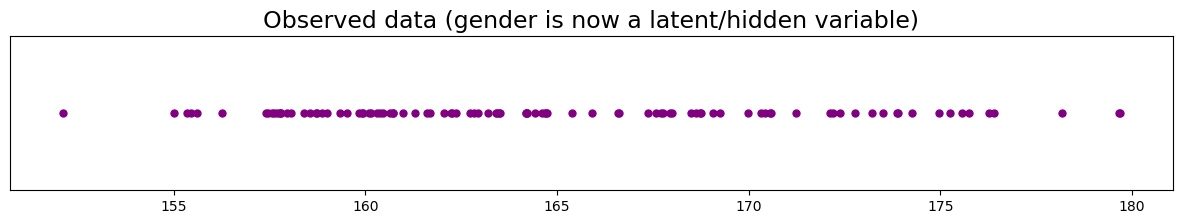

In [7]:
# Suppose the gender records for the data are 'erased' and we only have the height information.
# All we know is that the height data was generated via two Gaussians
figure = plt.figure(99)
plt.rcParams["figure.figsize"] = (15, 2)
alpha = np.linspace(0, 1, 100)
plt.plot(both_colours, np.zeros_like(both_colours), ".", color="purple", markersize=10)
plt.title("Observed data (gender is now a latent/hidden variable)", fontsize=17)
plt.yticks([])
plt.show()

In [8]:
def weight_of_colour(colour_likelihood, total_likelihood):
    """
    Compute the weight for each colour at each data point.
    """
    return colour_likelihood / total_likelihood


def estimate_mean(data, weight):
    """
    For each data point, multiply the point by the probability it
    was drawn from the colour's distribution (its "weight").

    Divide by the total weight: essentially, we're estimate the center of mass
    from our data points.
    """
    return np.sum(data * weight) / np.sum(weight)


def estimate_std(data, weight, mean):
    """
    For each data point, multiply the point's squared difference
    from a mean value by the probability it was drawn from
    that distribution (its "weight").

    Divide by the total weight: essentially, we're finding where
    the weight is centred among the values for the difference of
    each data point from the mean.

    This is the estimate of the variance, take the positive square
    root to find the standard deviation.
    """
    variance = np.sum(weight * (data - mean) ** 2) / np.sum(weight)
    return np.sqrt(variance)


def plot_guesses(
    red_mean_guess, blue_mean_guess, red_std_guess, blue_std_guess, alpha=1
):
    """
    Plot bell curves for the red and blue distributions given guesses for mean and standard deviation.


    """
    # set figure size and plot the purple dots

    plt.rcParams["figure.figsize"] = (15, 5)

    lkd_of_red = stats.norm(red_mean_guess, red_std_guess).pdf(both_colours)
    lkd_of_blue = stats.norm(blue_mean_guess, blue_std_guess).pdf(both_colours)

    red_weight = weight_of_colour(lkd_of_red, lkd_of_red + lkd_of_blue)
    # blue_weight = weight_of_colour(lkd_of_blue, lkd_of_red+lkd_of_blue)

    for pt_cnt in range(len(both_colours)):
        plt.plot(
            both_colours[pt_cnt],
            0,
            ".",
            color=red_weight[pt_cnt] * np.asarray([1, 0, 0])
            + (1 - red_weight[pt_cnt]) * np.asarray([0, 0, 1]),
            markersize=10,
        )

    # compute the size of the x axis
    lo = np.floor(both_colours.min()) - 1
    hi = np.ceil(both_colours.max()) + 1
    x = np.linspace(lo, hi, 500)

    # plot the bell curves
    plt.plot(
        x, stats.norm(red_mean_guess, red_std_guess).pdf(x), color="r", alpha=alpha
    )
    plt.plot(
        x, stats.norm(blue_mean_guess, blue_std_guess).pdf(x), color="b", alpha=alpha
    )

    # vertical dotted lines for the mean of each colour - find the height
    # first (i.e. the probability of the mean of the colour group)
    r_height = stats.norm(red_mean_guess, red_std_guess).pdf(red_mean_guess)
    b_height = stats.norm(blue_mean_guess, blue_std_guess).pdf(blue_mean_guess)

    plt.vlines(red_mean_guess, 0, r_height, "r", "--", alpha=alpha)
    plt.vlines(blue_mean_guess, 0, b_height, "b", "--", alpha=alpha)

In [9]:
# Initial estimates for the mean
red_mean_guess = 150
blue_mean_guess = 180

# Initial estimates for the standard deviation
red_std_guess = 1
blue_std_guess = 1

N_ITER = 20  # number of iterations of EM

alphas = 1  # transparency of curves to plot for each iteration-- ignored

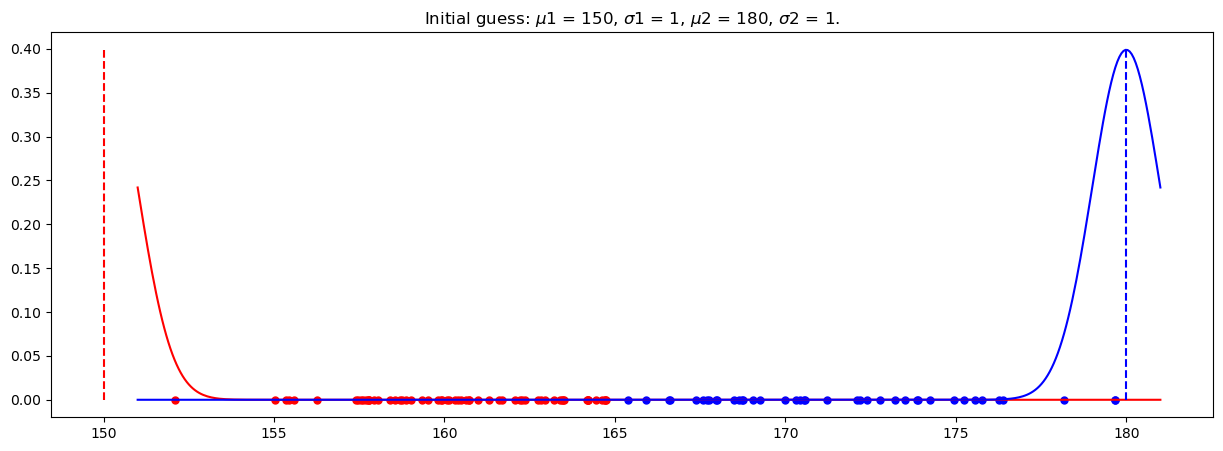

In [10]:
plot_guesses(red_mean_guess, blue_mean_guess, red_std_guess, blue_std_guess)
plt.title(
    "Initial guess: $\mu1$ = {}, $\sigma1$ = {}, $\mu2$ = {}, $\sigma2$ = {}.".format(
        red_mean_guess, red_std_guess, blue_mean_guess, blue_std_guess, fontsize=17
    )
)
plt.show()

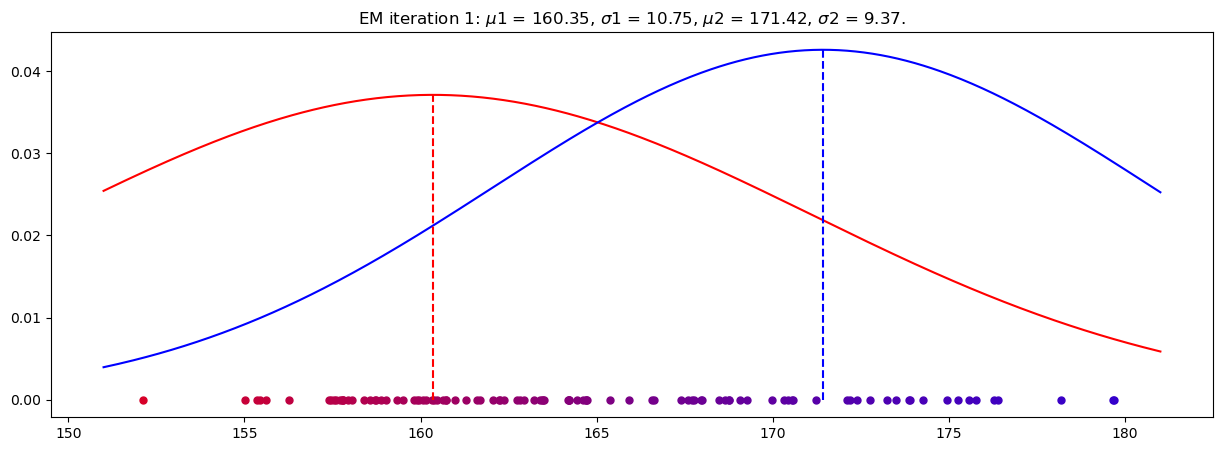

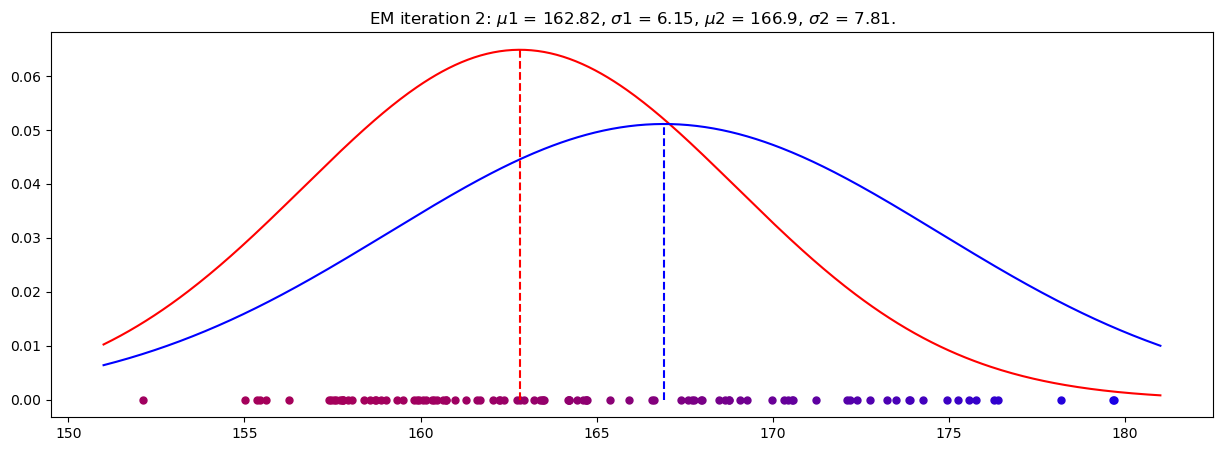

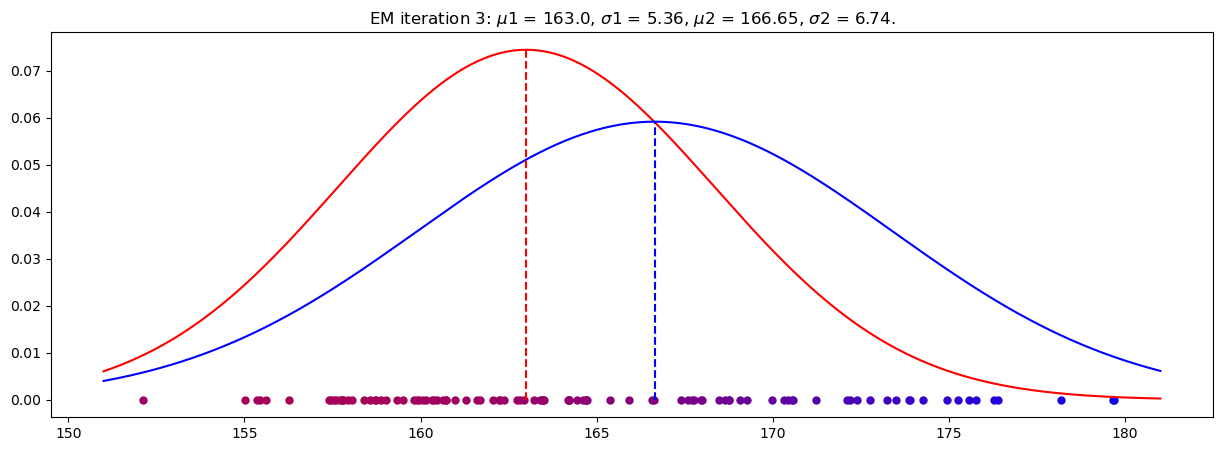

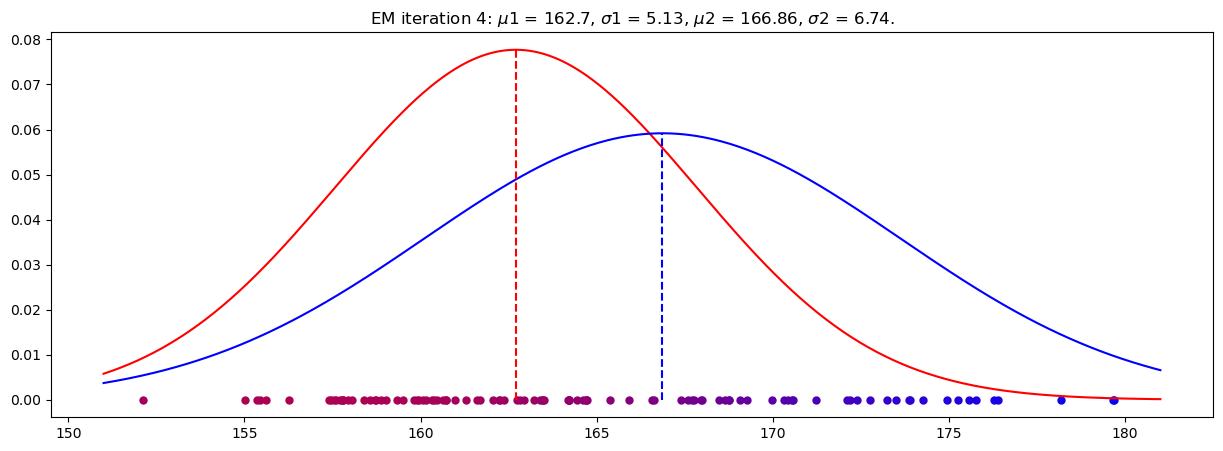

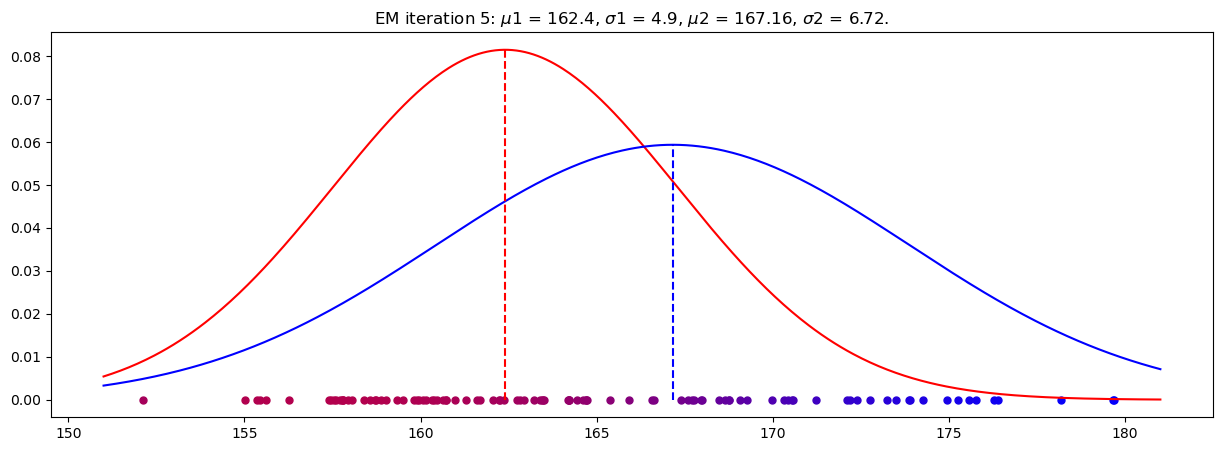

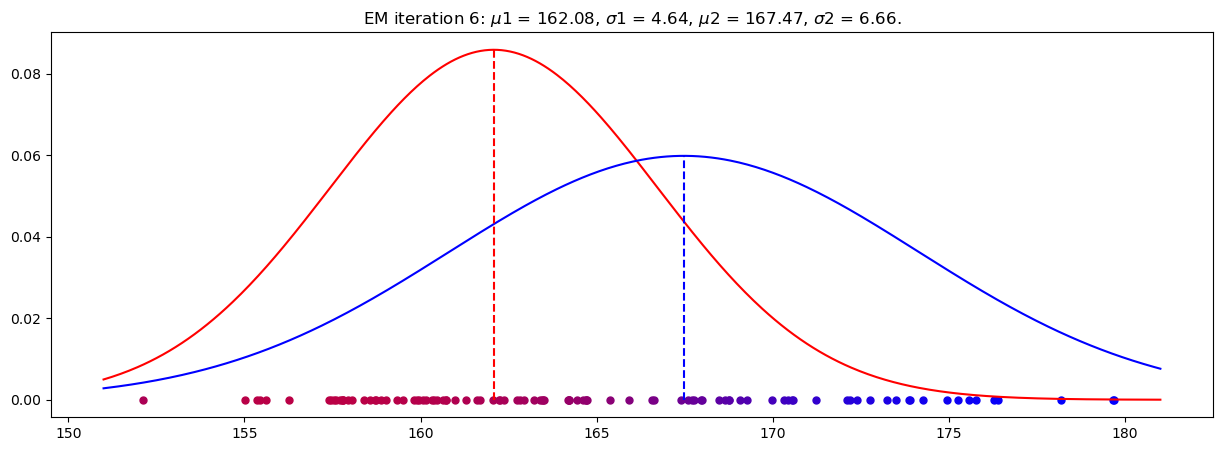

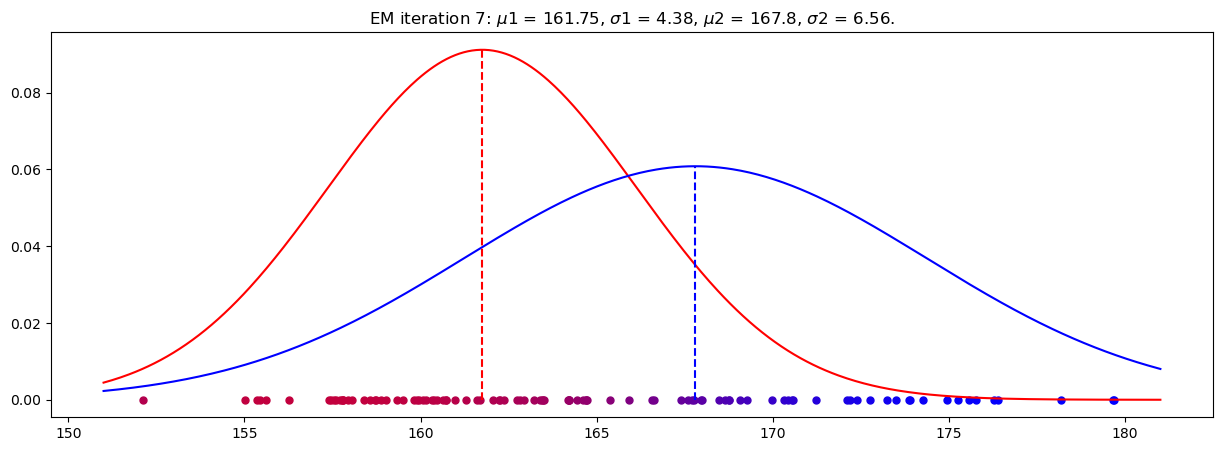

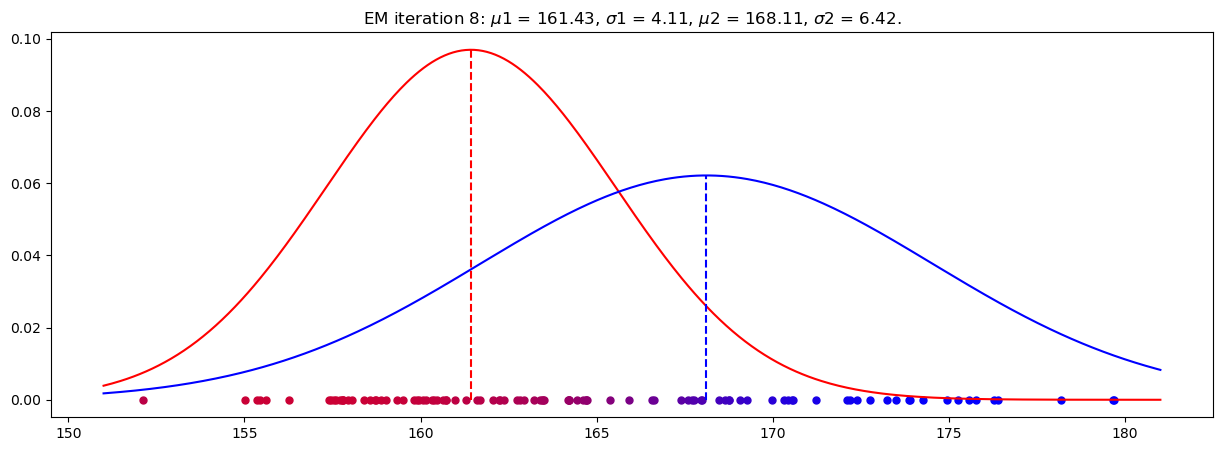

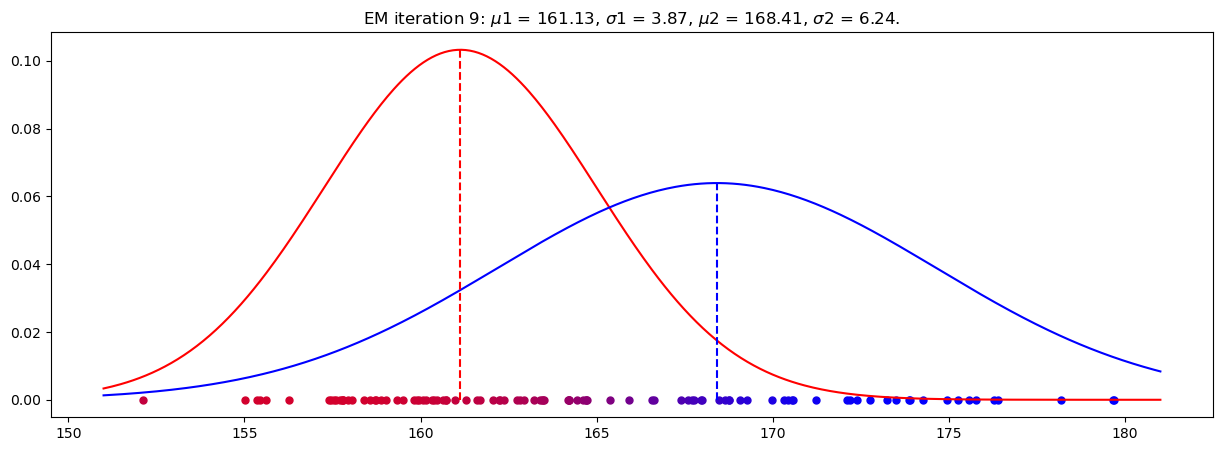

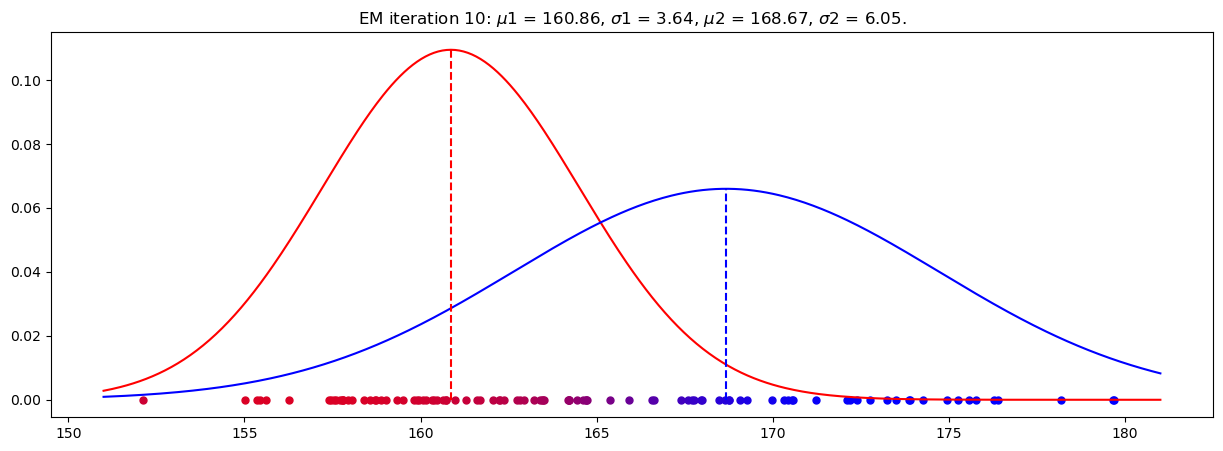

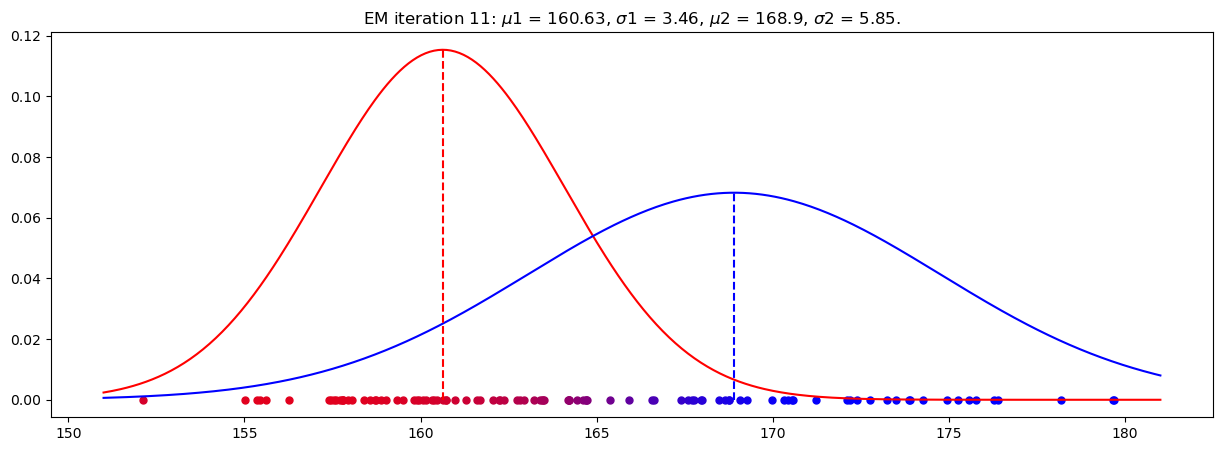

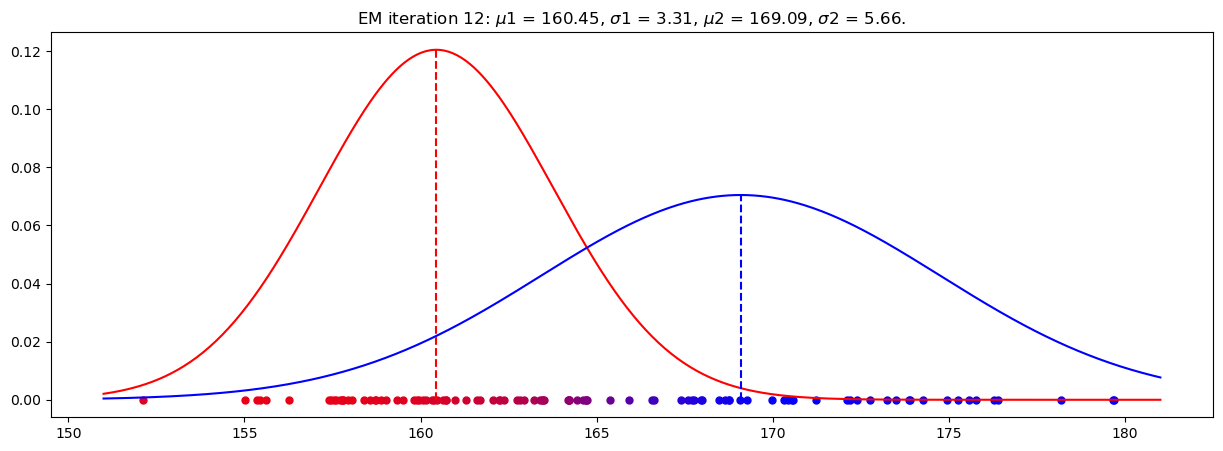

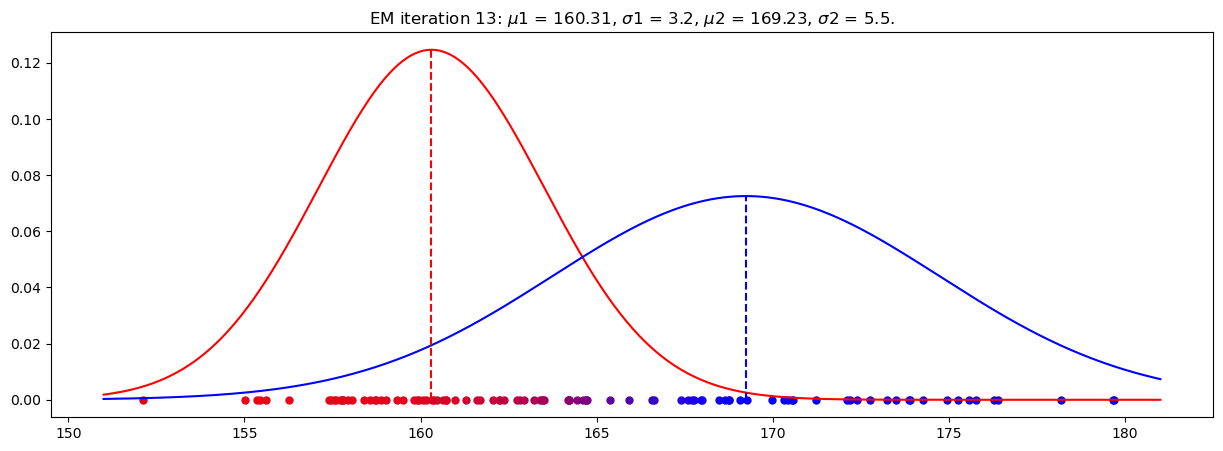

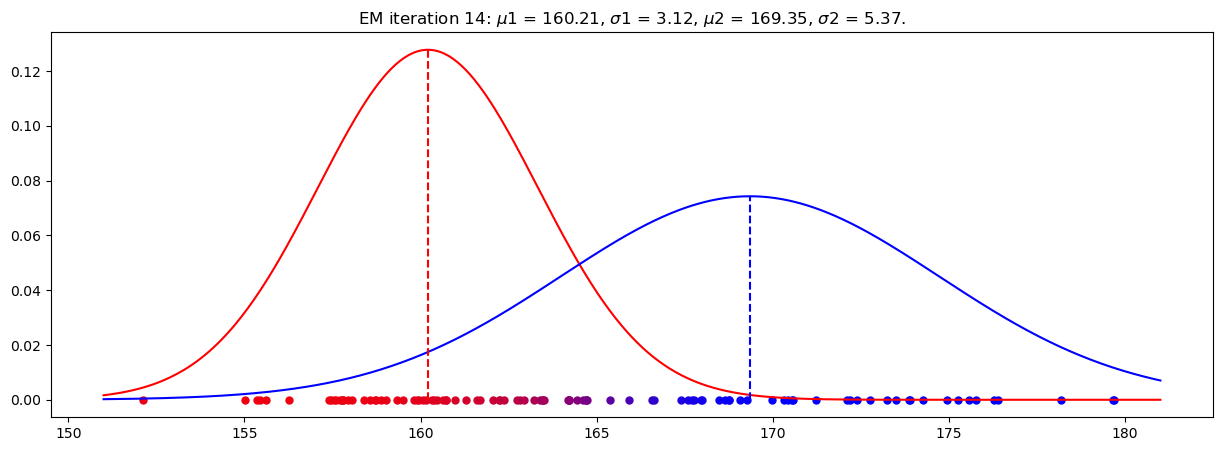

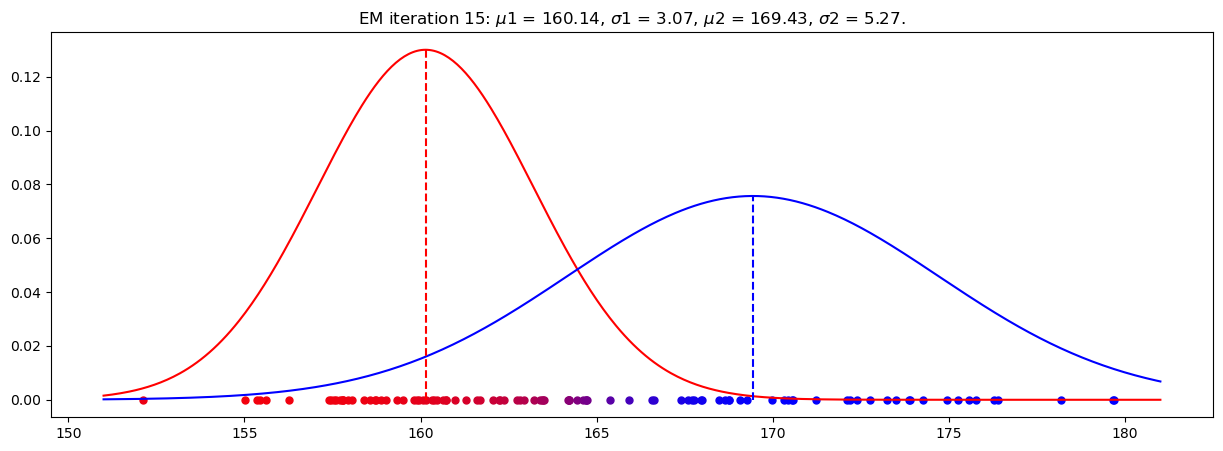

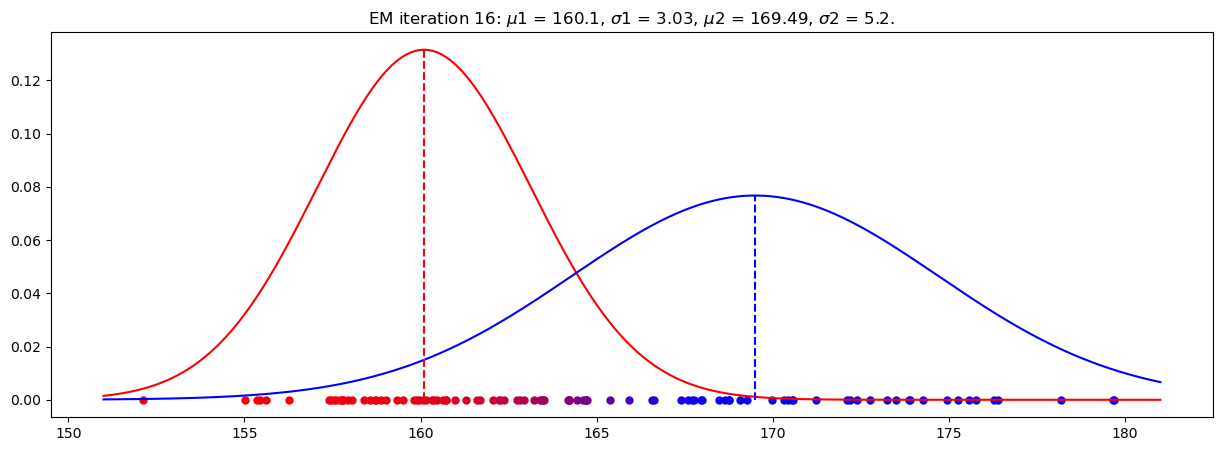

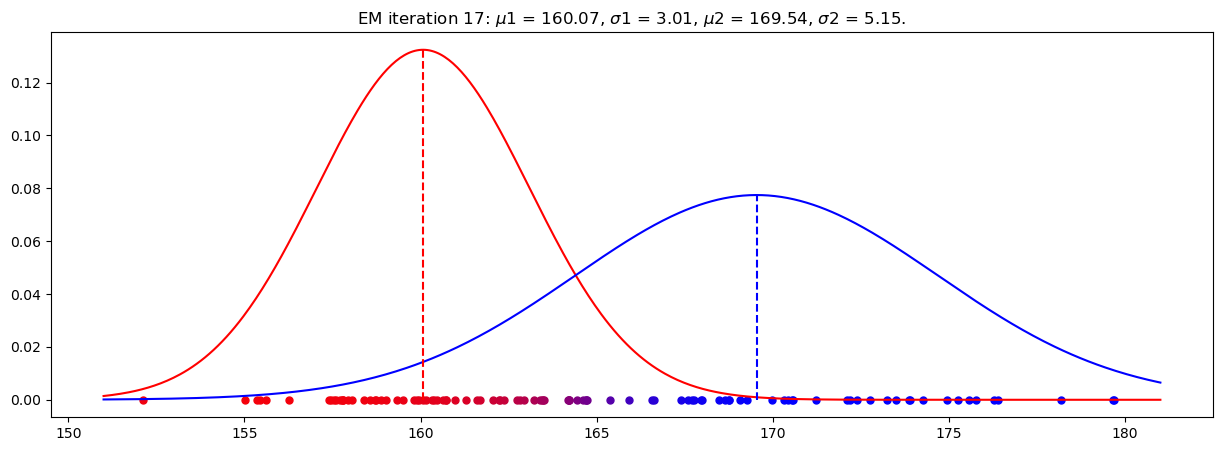

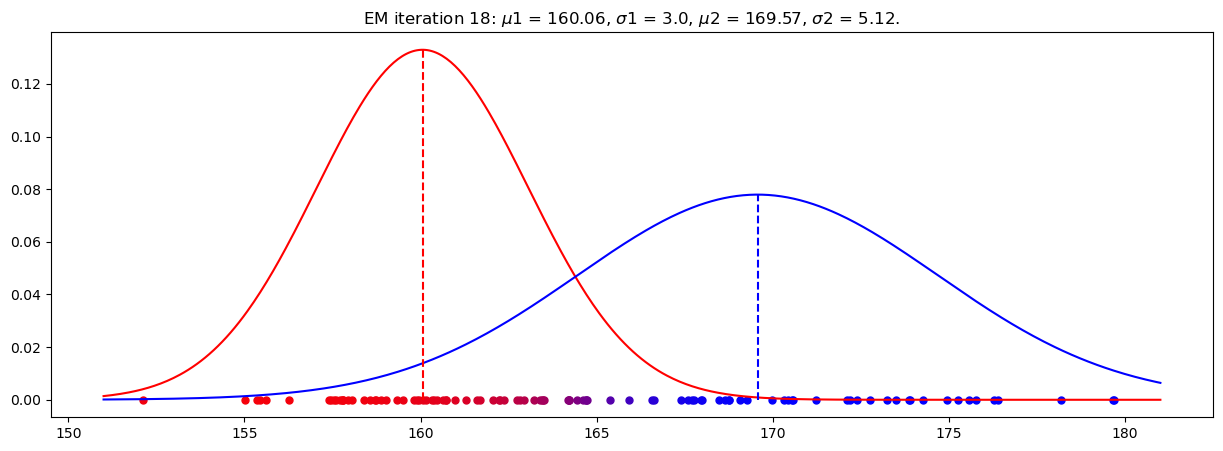

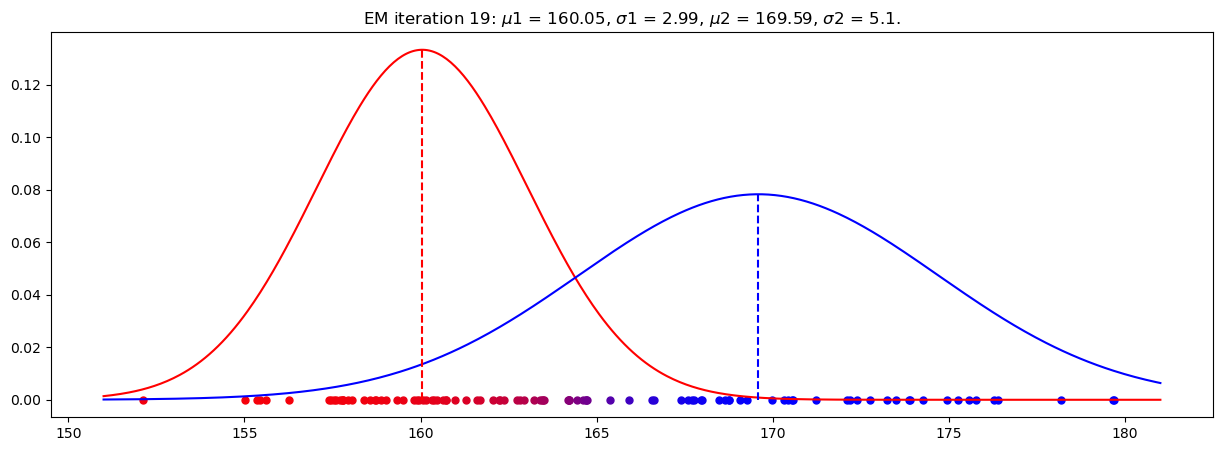

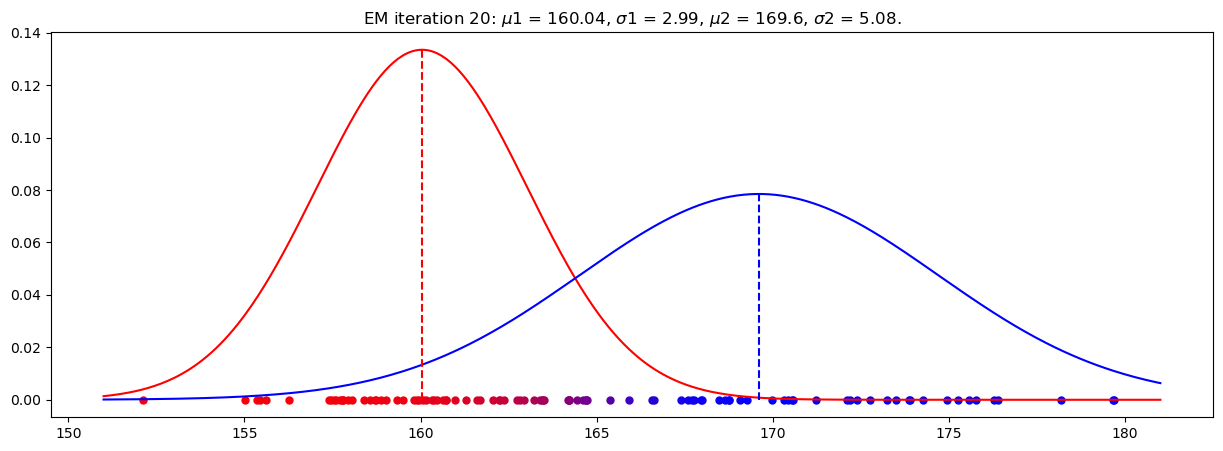

In [11]:
for iter in range(N_ITER):

    ## Expectation step
    ## ----------------
    lkd_of_red = stats.norm(red_mean_guess, red_std_guess).pdf(both_colours)
    lkd_of_blue = stats.norm(blue_mean_guess, blue_std_guess).pdf(both_colours)

    red_weight = weight_of_colour(lkd_of_red, lkd_of_red + lkd_of_blue)
    blue_weight = weight_of_colour(lkd_of_blue, lkd_of_red + lkd_of_blue)

    wgt_red = np.where(red_weight > blue_weight)

    # Maximisation step
    ## -----------------

    # N.B. it should not ultimately matter if compute the new standard deviation guess
    # before or after the new mean guess

    red_std_guess = estimate_std(both_colours, red_weight, red_mean_guess)
    blue_std_guess = estimate_std(both_colours, blue_weight, blue_mean_guess)

    red_mean_guess = estimate_mean(both_colours, red_weight)
    blue_mean_guess = estimate_mean(both_colours, blue_weight)

    # print(red_mean_guess,red_std_guess,blue_mean_guess,blue_std_guess)
    plt.figure(iter + 1)
    plot_guesses(
        red_mean_guess, blue_mean_guess, red_std_guess, blue_std_guess, alpha=1
    )

    plt.title(
        r"EM iteration {}: $\mu1$ = {}, $\sigma1$ = {}, $\mu2$ = {}, $\sigma2$ = {}.".format(
            iter + 1,
            round(red_mean_guess, 2),
            round(red_std_guess, 2),
            round(blue_mean_guess, 2),
            round(blue_std_guess, 2),
            fontsize=17,
        )
    )